In [1]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from keras.applications.vgg16 import (
    VGG16, 
    preprocess_input, 
    decode_predictions)



Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13778028858361820601
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6707519816
locality {
  bus_id: 1
}
incarnation: 3769508365413443584
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
#assigns GPU to backend (dont use this code if running off CPU)
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
#Confusion Matrix plot from scikitlearn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [328]:
#split animals folder into training, validation, and testing sets

import split_folders
split_folders.ratio('./greyscale2', output="FreshBatch", seed=1337, ratio=(.8, .1, .1))

In [380]:
#Assign Folder Paths
train_path = './split_images/train'
valid_path = './split_images/val'
test_path = './split_images/test'

gtrain_path = './grey_rgb/train'
gvalid_path = './grey_rgb/val'
gtest_path = './grey_rgb/test'

ftrain_path = './freshbatch/train'
fvalid_path = './freshbatch/val'
ftest_path = './freshbatch/test'

In [393]:
# assign batches for training and testing

train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['coyote','grey fox','kit fox','tortoise'],batch_size=391)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['coyote','grey fox','kit fox','tortoise'],batch_size=5)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['coyote','grey fox','kit fox','tortoise'],batch_size=53)

gtrain_batches = ImageDataGenerator().flow_from_directory(gtrain_path, target_size=(224,224), classes=['coyote','grey fox','kit fox','tortoise'],batch_size=979)
gvalid_batches = ImageDataGenerator().flow_from_directory(gvalid_path, target_size=(224,224), classes=['coyote','grey fox','kit fox','tortoise'],batch_size=5)
gtest_batches = ImageDataGenerator().flow_from_directory(gtest_path, target_size=(224,224), classes=['coyote','grey fox','kit fox','tortoise'],batch_size=63)

ftrain_batches = ImageDataGenerator().flow_from_directory(ftrain_path, target_size=(224,224), classes=['coyote','fox','jack rabbit'],batch_size=669)
fvalid_batches = ImageDataGenerator().flow_from_directory(fvalid_path, target_size=(224,224), classes=['coyote','fox','jack rabbit'],batch_size=83)
ftest_batches = ImageDataGenerator().flow_from_directory(ftest_path, target_size=(224,224), classes=['coyote','fox','jack rabbit'],batch_size=1)

Found 391 images belonging to 4 classes.
Found 47 images belonging to 4 classes.
Found 53 images belonging to 4 classes.
Found 979 images belonging to 4 classes.
Found 121 images belonging to 4 classes.
Found 126 images belonging to 4 classes.
Found 1294 images belonging to 3 classes.
Found 161 images belonging to 3 classes.
Found 163 images belonging to 3 classes.


In [815]:
ftest_batches.class_indices
from keras.models import load_model

model7 = Sequential()
for layer in vgg16_model.layers[:-1]:
    model7.add(layer)
    for layer in model7.layers:
        layer.trainable = False
model7.add(Dense(4, activation='softmax'))
model7.load_weights('re-trained.h5')

In [816]:
model7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [5]:
#function to plot images

def plots(ims, figsize=(12,6),rows=2, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        

c:\users\tpython\anaconda3\envs\tfgpu15\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


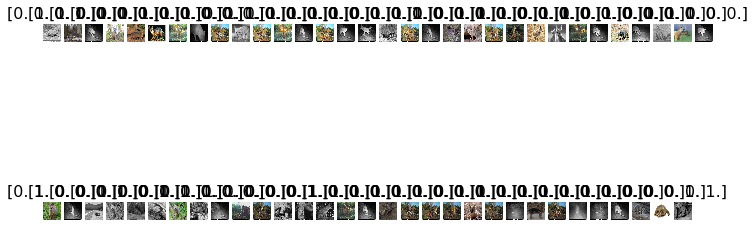

In [798]:
#Check out images
ims, labels = next(gtest_batches)
plots(ims, titles=labels)

In [367]:
#load VGG16 to train
vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [368]:
#copy VGG16 all layer except last output layer to new sequential model
model5 = Sequential()
for layer in vgg16_model.layers[:-1]:
    model5.add(layer)
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [369]:
#freeze all layers but the last output layer
for layer in model5.layers:
    layer.trainable = False

In [370]:
#add  dense 4 category output layer to model for retraining
model5.add(Dense(3, activation='softmax'))


model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [371]:
# compile with adam optimizer 
#model5.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model5.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [372]:
# create datagens to flow data into fit generator/model trainer

batch_size = 32

train_datagen = ImageDataGenerator(

            rescale=1./255,
            rotation_range=20,
            shear_range=0.2,
            channel_shift_range=0.2,
            # samplewise_center=True,
            # samplewise_std_normalization=True,
            featurewise_std_normalization=True,
            horizontal_flip=True,
            zoom_range=[0.9, 1])

test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
        './freshbatch/val',
        color_mode = 'rgb',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            shear_range=0.2,
            channel_shift_range=0.2,
            # samplewise_center=True,
            # samplewise_std_normalization=True,
            featurewise_std_normalization=True,
            horizontal_flip=True,
            zoom_range=[0.9, 1])

train_generator = train_datagen.flow_from_directory(
        './freshbatch/train',  # this is the target directory
        color_mode = 'rgb',
        target_size=(224, 224),  # all images will be resized to 299x299
        batch_size=32,
        class_mode='categorical')

steps_per_epoch = train_generator.n//train_generator.batch_size

calc_n_batches_per_epoch(n_total, batch_size, drop_remainder=True)

Found 161 images belonging to 3 classes.
Found 1294 images belonging to 3 classes.


40

In [253]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

ftrain_batches

In [373]:
#fit the model

model5.fit_generator(train_generator, steps_per_epoch=1294, validation_data=validation_generator, epochs=10, verbose=2 )

Epoch 1/10
 - 426s - loss: 0.7178 - acc: 0.7166 - val_loss: 0.6177 - val_acc: 0.7516
Epoch 2/10
 - 423s - loss: 0.5661 - acc: 0.7914 - val_loss: 0.5025 - val_acc: 0.8137
Epoch 3/10
 - 452s - loss: 0.5172 - acc: 0.8103 - val_loss: 0.4872 - val_acc: 0.8385
Epoch 4/10
 - 425s - loss: 0.4878 - acc: 0.8200 - val_loss: 0.4765 - val_acc: 0.8509
Epoch 5/10
 - 428s - loss: 0.4713 - acc: 0.8256 - val_loss: 0.4962 - val_acc: 0.8385
Epoch 6/10
 - 428s - loss: 0.4548 - acc: 0.8327 - val_loss: 0.4354 - val_acc: 0.8385
Epoch 7/10
 - 419s - loss: 0.4393 - acc: 0.8377 - val_loss: 0.4354 - val_acc: 0.8447
Epoch 8/10
 - 417s - loss: 0.4320 - acc: 0.8428 - val_loss: 0.4244 - val_acc: 0.8634
Epoch 9/10
 - 422s - loss: 0.4205 - acc: 0.8450 - val_loss: 0.4268 - val_acc: 0.8385
Epoch 10/10
 - 420s - loss: 0.4126 - acc: 0.8501 - val_loss: 0.4139 - val_acc: 0.8509


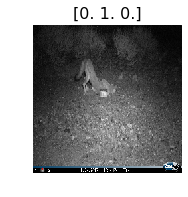

In [469]:
#Check out images
ims, labels = next(ftest_batches)
plots(ims, titles=labels)

1/1 [==============================] - 0s 31ms/step
Confusion matrix, without normalization
[[0 0]
 [1 0]]


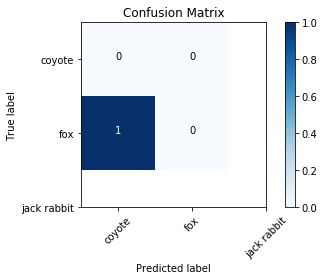

In [470]:
predictions5 = model5.predict_generator(ftest_batches, steps=1, verbose=1)
cm = confusion_matrix(labels.argmax(axis=1), predictions5.argmax(axis=1))
cm_plot_labels = ['coyote','fox','jack rabbit']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [400]:
#crteate classification report to display results on test batch predictions
from sklearn.metrics import classification_report
y_true = labels.argmax(axis=1)
y_pred = predictions5.argmax(axis=1)
target_names = ['coyote', 'fox', 'jack rabbit']
print(classification_report(y_true, y_pred, target_names=target_names))

ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

In [485]:
predictionz = model5.predict_generator(ftest_batches,steps=1)

label = predictionz.argmax(axis=1)[0]

In [489]:
predictionz = model5.predict_generator(ftest_batches,steps=1)
label = predictionz.argmax(axis=1)[0]
if label == 0:
    print('Coyote'),
elif label == 1:
    print('fox'),
elif label == 2:
    print('jack rabbit')

jack_rabbit


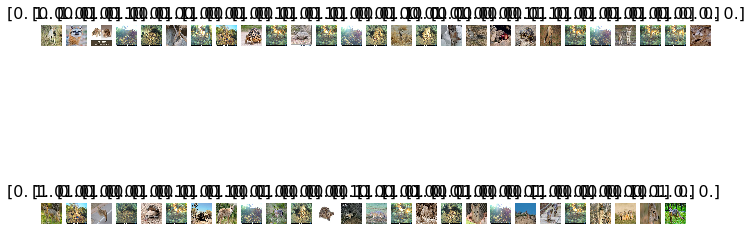

In [70]:
#assign test images to test batch and display
test_ims, test_labels = next(test_batches)
plots(test_ims, titles=test_labels)

1/1 [==============================] - 0s 469ms/step
Confusion matrix, without normalization
[[26  1  0  0]
 [ 2  8  1  0]
 [ 1  3  3  0]
 [ 0  0  0  8]]


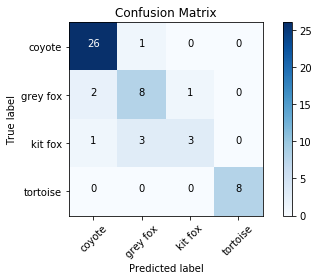

In [71]:
#create confusion matrix to display results
predictions = model2.predict_generator(test_batches, steps=1, verbose=1)
cm = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))
cm_plot_labels = ['coyote', 'grey fox','kit fox', 'tortoise']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [72]:
#crteate classification report to display results on test batch predictions
from sklearn.metrics import classification_report
y_true = test_labels.argmax(axis=1)
y_pred = predictions.argmax(axis=1)
target_names = ['coyote', 'grey fox','kit fox', 'tortoise']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      coyote       0.90      0.96      0.93        27
    grey fox       0.67      0.73      0.70        11
     kit fox       0.75      0.43      0.55         7
    tortoise       1.00      1.00      1.00         8

   micro avg       0.85      0.85      0.85        53
   macro avg       0.83      0.78      0.79        53
weighted avg       0.85      0.85      0.84        53



In [283]:
model.save_weights('Re-trained2.h5')

In [50]:
#now try to retrain inceptionV3 model
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 4 classes
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model1 = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
    
batch_size = 16

#assign training,testing, and validation generators
train_datagen1 = ImageDataGenerator(
        rotation_range=20,
        shear_range=0.2,
        channel_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        )

test_datagen1 = ImageDataGenerator(rescale=1./255)

validation_generator1 = test_datagen1.flow_from_directory(
        valid_path,
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='categorical')



train_generator1 = train_datagen1.flow_from_directory(
        './split_images/train',  # this is the target directory
        target_size=(299, 299),  # all images will be resized to 299x299
        batch_size=batch_size,
        class_mode='categorical')
    

steps_per_epoch = train_generator1.n//train_generator1.batch_size

Found 47 images belonging to 4 classes.
Found 391 images belonging to 4 classes.


In [51]:

# compile the model (should be done *after* setting layers to non-trainable)
model1.compile(optimizer='Adam', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
model1.fit_generator(train_generator1, steps_per_epoch=steps_per_epoch, validation_data=validation_generator1, epochs=5, verbose=2 )


# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

Epoch 1/5
 - 8s - loss: 1.1353 - val_loss: 0.3747
Epoch 2/5
 - 7s - loss: 0.5220 - val_loss: 0.1619
Epoch 3/5
 - 7s - loss: 0.2734 - val_loss: 0.3731
Epoch 4/5
 - 7s - loss: 0.3833 - val_loss: 0.2011
Epoch 5/5
 - 7s - loss: 0.3126 - val_loss: 0.2258


In [46]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model1.layers[:249]:
   layer.trainable = False
for layer in model1.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use adam with a low learning rate

model1.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model1.fit_generator(train_generator1, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, epochs=20, verbose=2 )


0 input_4
1 conv2d_189
2 batch_normalization_189
3 activation_189
4 conv2d_190
5 batch_normalization_190
6 activation_190
7 conv2d_191
8 batch_normalization_191
9 activation_191
10 max_pooling2d_9
11 conv2d_192
12 batch_normalization_192
13 activation_192
14 conv2d_193
15 batch_normalization_193
16 activation_193
17 max_pooling2d_10
18 conv2d_197
19 batch_normalization_197
20 activation_197
21 conv2d_195
22 conv2d_198
23 batch_normalization_195
24 batch_normalization_198
25 activation_195
26 activation_198
27 average_pooling2d_19
28 conv2d_194
29 conv2d_196
30 conv2d_199
31 conv2d_200
32 batch_normalization_194
33 batch_normalization_196
34 batch_normalization_199
35 batch_normalization_200
36 activation_194
37 activation_196
38 activation_199
39 activation_200
40 mixed0
41 conv2d_204
42 batch_normalization_204
43 activation_204
44 conv2d_202
45 conv2d_205
46 batch_normalization_202
47 batch_normalization_205
48 activation_202
49 activation_205
50 average_pooling2d_20
51 conv2d_201
52 

1/1 [==============================] - 2s 2s/step
Confusion matrix, without normalization
[[27  0  0  0]
 [11  0  0  0]
 [ 7  0  0  0]
 [ 8  0  0  0]]


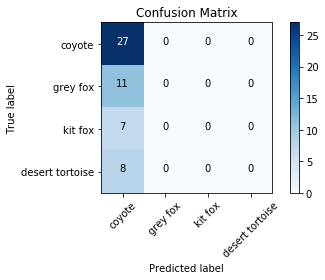

In [52]:
predictions2 = model1.predict_generator(test_batches, steps=1, verbose=1)
cm = confusion_matrix(test_labels.argmax(axis=1), predictions2.argmax(axis=1))
cm_plot_labels = ['coyote','grey fox','kit fox','desert tortoise']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')


In [53]:
v3y_true = test_labels.argmax(axis=1)
v3y_pred = predictions2.argmax(axis=1)
target_names = ['coyote', 'grey fox','kit fox', 'tortoise']
print(classification_report(v3y_true, v3y_pred, target_names=target_names))

              precision    recall  f1-score   support

      coyote       0.51      1.00      0.67        27
    grey fox       0.00      0.00      0.00        11
     kit fox       0.00      0.00      0.00         7
    tortoise       0.00      0.00      0.00         8

   micro avg       0.51      0.51      0.51        53
   macro avg       0.13      0.25      0.17        53
weighted avg       0.26      0.51      0.34        53



In [ ]:
model1.save_weights('terrible_model.h5')

In [ ]:
ftest_batches = ImageDataGenerator().flow_from_directory(ftest_path, target_size=(224,224), classes=['coyote','fox','jack rabbit'],batch_size=50)
predictions2 = model1.predict_generator(test_batches, steps=1, verbose=1)

In [ ]:
predictionz = model5.predict_generator(ftest_batches,steps=1)
label = predictionz.argmax(axis=1)[0]

def prediction_label(label)
if label == 0:
    print('Coyote'),
elif label == 1:
    print('fox'),
elif label == 2:
    print('jack rabbit')

In [604]:
import exifread
# Open image file for reading (binary mode)
path = './FreshBatch/test/coyote/coyote (1054).jpg'

f = open(path, 'rb')
# Return Exif tags
tags = exifread.process_file(f, stop_tag='EXIF')
#tags = exifread.process_file(f)
x = {}
for tag in tags.keys():

    #print ("Key: %s, value %s" % (tag, tags[tag]))
    #x[tag] = [tag[tags]]
    if tag not in ('JPEGThumbnail', 'TIFFThumbnail', 'Filename', 'EXIF MakerNote'):
      
        x[tag] = [tags[tag]]


In [626]:
x['EXIF DateTimeOriginal'][0]
comments = str(x['EXIF UserComment'])
ID= str(myList[0]).split(',')
CAM_ID = ID[14].split('=')[1]
CAM_ID

'417'

In [3]:
#Extracting CAMERA ID and DATETIME from image metadata

path = './master'
import os
folder = os.fsencode(path)

filenames = []

for file in os.listdir(folder):
    filename = os.fsdecode(file)

    if filename.endswith( ( '.JPG', '.jpg') ): # whatever file types you're using...
        filenames.append(path +'/'+ filename)

In [4]:
filenames[:10]

['./master/master (1).JPG',
 './master/master (10).JPG',
 './master/master (100).JPG',
 './master/master (1000).JPG',
 './master/master (1001).JPG',
 './master/master (1002).JPG',
 './master/master (1003).JPG',
 './master/master (1004).JPG',
 './master/master (1005).JPG',
 './master/master (1006).JPG']

In [240]:
wow = []
whacklist = ['5sec', '5min', 'FAP']
import pandas as pd
import exifread


for filename in filenames:
    path = filename
    f = open(path, 'rb')
        # Return Exif tags
    tags = exifread.process_file(f)
        
    cam = {}
    CAM_ID = []
    DATETIME = []
    IMG = []
    x = {}
    #print(path)
    for tag in tags.keys():
        x[tag] = [tags[tag]]
    
                        
    try:       
        date = str(x['EXIF DateTimeOriginal'])
        datetime = date.split('=')[1].split('@')[0]
        cam['DATETIME'] = datetime
        comments = str(x['EXIF UserComment'])
        #print(comments)
        ID= str(comments).split(',')
        CAM_ID = ID[14].split('=')[1]
       # print(CAM_ID)
        if CAM_ID not in whacklist:
            cam['CAM_ID'] = CAM_ID
        if CAM_ID in whacklist:
            CAM_ID = ID[12].split('=')[1]
            cam['CAM_ID'] = CAM_ID
        cam['IMG'] = path
        #print(path)
        wow.append(cam)
    except:
         print('error')
       



In [241]:
df = pd.DataFrame(wow)
# df2 = df.groupby([CAM_ID]).mean()
df['CAM_ID'].unique()
#df.loc[df['CAM_ID'] == '5min']

df2 = df.groupby(['CAM_ID','DATETIME']).count()
df.head()

,CAM_ID,DATETIME,IMG
0,406,2016:02:05 00:45:23,./master/master (1).JPG
1,406,2016:01:30 23:34:38,./master/master (10).JPG
2,426,2016:02:01 20:11:22,./master/master (100).JPG
3,417,2016:02:03 21:59:30,./master/master (1000).JPG
4,417,2016:02:03 21:59:30,./master/master (1001).JPG


In [242]:
from datetime import datetime
import pandas as pd

df['DATETIME'] = df['DATETIME'].astype(str)
df['year'], df['hours'] = df['DATETIME'].str.split(' ', 1).str
df['newyear'] = df['year'].str.replace(':', '-')
df["dt"] = df["newyear"].map(str) + ' ' + df["hours"]

df['Date'] = pd.to_datetime(df['dt'], format="%Y%m%d %H:%M:%S")

df = df.drop(columns = ['dt', 'newyear', 'year', 'hours', 'DATETIME'])

df = df.sort_values(by=['CAM_ID','Date'])
df['delta'] = (df['Date']-df['Date'].shift())
 
df = df.sort_values(by=['CAM_ID','Date'])
df['events'] = 1

In [228]:
df.to_csv('events.csv', encoding='utf-8', index=False)

In [236]:
df502 = df.loc[df['CAM_ID'] == '502']
df502.head()
df502['delta'].dtype
df.head()

,CAM_ID,IMG,Date,delta,events
1543,403,./master/master (270).JPG,2016-01-30 16:07:41,NaT,0
1544,403,./master/master (271).JPG,2016-01-30 16:07:41,0 days 00:00:00,0
1800,403,./master/master (501).JPG,2016-02-07 05:38:37,7 days 13:30:56,1
1801,403,./master/master (502).JPG,2016-02-09 00:58:28,1 days 19:19:51,1
1802,403,./master/master (503).JPG,2016-02-09 00:58:28,0 days 00:00:00,0


In [226]:
#extracting 'events' from time delta


x = pd.Timedelta(minutes=(20))
for i in range(1,len(df.index)-1):
    df['events'][i] = 0
    if df['delta'][i] > x:
        df['events'][i] = 1
    
    

c:\users\tpython\anaconda3\envs\tfgpu15\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\tpython\anaconda3\envs\tfgpu15\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [234]:
df['delta'][1]
pd.Timedelta(minutes=(20))
df2 = df.groupby(['CAM_ID']).sum()
df2

,events
CAM_ID,
403,28
405,98
406,9
414,54
416,28
417,19
421,0
422,43
426,41


In [237]:
df2.to_csv('eventsfinal.csv', encoding='utf-8')

In [6]:
split_folders.ratio('./datasets/animals', output="allcolor", seed=1337, ratio=(.8, .1, .1))

ftrain_path = './allcolor/train'
fvalid_path = './allcolor/val'
ftest_path = './allcolor/test'

ftrain_batches = ImageDataGenerator().flow_from_directory(ftrain_path, target_size=(224,224), classes=['coyote','grey fox','kit fox','tortoise'],batch_size=32)
fvalid_batches = ImageDataGenerator().flow_from_directory(fvalid_path, target_size=(224,224), classes=['coyote','grey fox','kit fox', 'tortoise'],batch_size=32)
ftest_batches = ImageDataGenerator().flow_from_directory(ftest_path, target_size=(224,224), classes=['coyote','grey fox','kit fox', 'tortoise'],batch_size=32)

Found 979 images belonging to 4 classes.
Found 121 images belonging to 4 classes.
Found 126 images belonging to 4 classes.


In [7]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

img_rows, img_cols, img_channel = 224, 224, 3

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

In [16]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(4, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(
        './allcolor/val',
        color_mode = 'rgb',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 121 images belonging to 4 classes.


In [48]:

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 20


train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            shear_range=0.1,
            channel_shift_range=0.1,
            # samplewise_center=True,
            # samplewise_std_normalization=True,
           #featurewise_std_normalization=True,
            horizontal_flip=True,
            zoom_range=[0.9, 1])

train_generator = train_datagen.flow_from_directory(
        './allcolor/train',  # this is the target directory
        color_mode = 'rgb',
        target_size=(224, 224),  # all images will be resized to 299x299
        batch_size=32,
        class_mode='categorical')

steps_per_epoch = train_generator.n//train_generator.batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)]
)


Found 979 images belonging to 4 classes.
Epoch 1/20
30/30 [==============================] - 21s 685ms/step - loss: 0.1368 - acc: 0.9428 - val_loss: 0.1706 - val_acc: 0.9256
Epoch 2/20
30/30 [==============================] - 20s 679ms/step - loss: 0.1306 - acc: 0.9466 - val_loss: 0.1742 - val_acc: 0.9256
Epoch 3/20
30/30 [==============================] - 20s 683ms/step - loss: 0.1136 - acc: 0.9540 - val_loss: 0.1831 - val_acc: 0.9194
Epoch 4/20
30/30 [==============================] - 21s 692ms/step - loss: 0.1171 - acc: 0.9506 - val_loss: 0.1816 - val_acc: 0.9215
Epoch 5/20
30/30 [==============================] - 21s 693ms/step - loss: 0.1103 - acc: 0.9583 - val_loss: 0.1571 - val_acc: 0.9339
Epoch 6/20
30/30 [==============================] - 21s 685ms/step - loss: 0.0967 - acc: 0.9624 - val_loss: 0.1624 - val_acc: 0.9339
Epoch 7/20
30/30 [==============================] - 20s 682ms/step - loss: 0.0909 - acc: 0.9654 - val_loss: 0.1608 - val_acc: 0.9298
Epoch 8/20
30/30 [==========

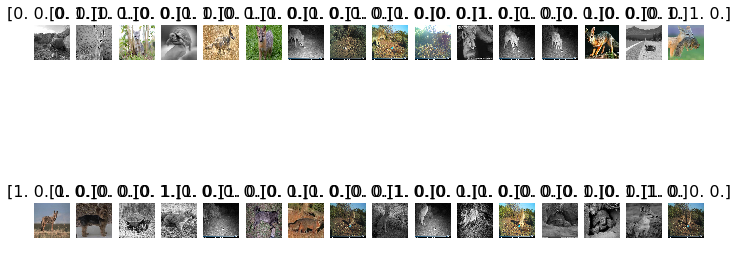

In [53]:

#assign test images to test batch and display
test_ims, test_labels = next(ftest_batches)
plots(test_ims, titles=test_labels)  


1/1 [==============================] - 0s 261ms/step
Confusion matrix, without normalization
[[6 3 3 3]
 [2 2 2 0]
 [3 2 0 0]
 [3 2 1 0]]


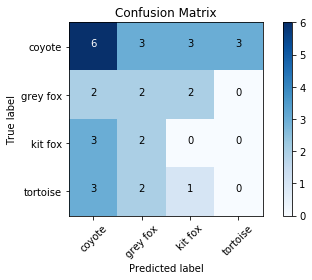

In [54]:

#create confusion matrix to display results
prediction = model.predict_generator(ftest_batches, steps=1, verbose=1)
cm = confusion_matrix(test_labels.argmax(axis=1), prediction.argmax(axis=1))
cm_plot_labels = ['coyote', 'grey fox','kit fox', 'tortoise']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [55]:

#crteate classification report to display results on test batch predictions
from sklearn.metrics import classification_report
y_true = test_labels.argmax(axis=1)
y_pred = prediction.argmax(axis=1)
target_names = ['coyote', 'grey fox','kit fox', 'tortoise']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      coyote       0.43      0.40      0.41        15
    grey fox       0.22      0.33      0.27         6
     kit fox       0.00      0.00      0.00         5
    tortoise       0.00      0.00      0.00         6

   micro avg       0.25      0.25      0.25        32
   macro avg       0.16      0.18      0.17        32
weighted avg       0.24      0.25      0.24        32



In [35]:
model.save_weights('test-re-train.h5')